# Comparison of Neural Models on pretrained Word2Vec embeddings

## Feedforward Neural Network

Following an experiment to compare neural models, we discovered odd results showing that bag of words could outperform embeddings. This experiment attempts to tweak the embeddings to show the expected results under the assumption that the problem is not the amount of data. If the problem is the amount of data we will investigate this in another experiment.

Again, we will show Bag of Words results:

In [1]:
from scripts import training_helpers
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, MaxPooling2D, LSTM
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from pandas import DataFrame
from seaborn import boxplot
from notebooks.yelp.metrics import auroc, f1
import matplotlib.pyplot as plt
import json
import statistics

import gensim
import numpy as np

import tensorflow as tf
import pandas as pd

read_existing_embeddings = False

Using TensorFlow backend.


In [2]:
downloaded = tf.keras.utils.get_file(
             fname="opspam.pkl",
             origin="https://storage.googleapis.com/lucas0/opspam.pkl",
             extract=False)
data_frame = pd.read_pickle(downloaded).sample(frac=1).reset_index(drop=True)

raw_features = data_frame['review']
labels = [x for x in data_frame['deceptive']]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_features)
bow_features = tokenizer.texts_to_matrix(raw_features, mode='tfidf')

In [3]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

In [4]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)

In [5]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(corpus_vocab_size,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc, f1])
  return model

In [6]:
def evaluate_ffnn_model(train_X, train_y, test_X, test_y):
    ffnn_model = get_ff_bow_model()
    return ffnn_model.fit(train_X, train_y, epochs=25, batch_size=32, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                   validation_data=(test_X, test_y))

ff_bow_scores = run_cross_validate(evaluate_ffnn_model, bow_features, labels, splitter, cv=5, verbose=0)

Train on 1280 samples, validate on 320 samples
Epoch 1/25
1280/1280 [==============================] - 1s 497us/step - loss: 0.8263 - acc: 0.6672 - auroc: 0.7538 - f1: 0.6219 - val_loss: 0.6407 - val_acc: 0.8375 - val_auroc: 0.9231 - val_f1: 0.8379
Epoch 2/25
1280/1280 [==============================] - 0s 143us/step - loss: 0.4639 - acc: 0.9195 - auroc: 0.9695 - f1: 0.9164 - val_loss: 0.4904 - val_acc: 0.8750 - val_auroc: 0.9527 - val_f1: 0.8805
Epoch 3/25
1280/1280 [==============================] - 0s 140us/step - loss: 0.3079 - acc: 0.9789 - auroc: 0.9962 - f1: 0.9777 - val_loss: 0.4546 - val_acc: 0.8875 - val_auroc: 0.9554 - val_f1: 0.8835
Epoch 4/25
1280/1280 [==============================] - 0s 140us/step - loss: 0.2539 - acc: 0.9820 - auroc: 0.9989 - f1: 0.9821 - val_loss: 0.4448 - val_acc: 0.8750 - val_auroc: 0.9563 - val_f1: 0.8794
Epoch 5/25
1280/1280 [==============================] - 0s 143us/step - loss: 0.2207 - acc: 0.9930 - auroc: 1.0000 - f1: 0.9932 - val_loss: 0.418

Epoch 6/25
1280/1280 [==============================] - 0s 138us/step - loss: 0.2514 - acc: 0.9844 - auroc: 0.9961 - f1: 0.9841 - val_loss: 0.4579 - val_acc: 0.8531 - val_auroc: 0.9328 - val_f1: 0.8540
Epoch 7/25
1280/1280 [==============================] - 0s 133us/step - loss: 0.2242 - acc: 0.9891 - auroc: 0.9979 - f1: 0.9884 - val_loss: 0.4625 - val_acc: 0.8688 - val_auroc: 0.9316 - val_f1: 0.8723
Epoch 8/25
1280/1280 [==============================] - 0s 130us/step - loss: 0.2005 - acc: 0.9922 - auroc: 0.9989 - f1: 0.9926 - val_loss: 0.4719 - val_acc: 0.8625 - val_auroc: 0.9328 - val_f1: 0.8652
Epoch 9/25
1280/1280 [==============================] - 0s 130us/step - loss: 0.1923 - acc: 0.9922 - auroc: 0.9988 - f1: 0.9925 - val_loss: 0.4735 - val_acc: 0.8594 - val_auroc: 0.9389 - val_f1: 0.8569
Epoch 10/25
1280/1280 [==============================] - 0s 130us/step - loss: 0.1741 - acc: 0.9930 - auroc: 0.9997 - f1: 0.9928 - val_loss: 0.4571 - val_acc: 0.8625 - val_auroc: 0.9409 - val_

And now we will get results for embeddings. This time I will use pretrained Word2Vec. Although this was not trained directly on words from our dataset, the Word2Vec has a higher dimensionality (making it harder to run on our machines) and so may show better results.

In [7]:
def results(scores):
    bests = []
    for his in scores:
        best = None
        min_val_loss = 99999
        h = his.history
        for i, val_loss in enumerate(h['val_loss']):
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best = { 'val_loss': val_loss, 'val_accuracy': h['val_acc'][i], 'val_auroc': h['auroc'][i], 'val_f1': h['val_f1'][i]}
        bests.append(best)
    return bests

In [8]:
bests = results(ff_bow_scores)

In [9]:
bests, statistics.mean([x['val_accuracy'] for x in bests])

([{'val_accuracy': 0.884375,
   'val_auroc': 0.9999019607843138,
   'val_f1': 0.88272345662117,
   'val_loss': 0.37886111736297606},
  {'val_accuracy': 0.8875,
   'val_auroc': 1.0,
   'val_f1': 0.8816700756549836,
   'val_loss': 0.3891655921936035},
  {'val_accuracy': 0.85625,
   'val_auroc': 0.9997023809523811,
   'val_f1': 0.8591303348541259,
   'val_loss': 0.4492654412984848},
  {'val_accuracy': 0.90625,
   'val_auroc': 1.0,
   'val_f1': 0.9021806597709656,
   'val_loss': 0.3703372567892075},
  {'val_accuracy': 0.884375,
   'val_auroc': 0.9998015873015873,
   'val_f1': 0.8780216753482819,
   'val_loss': 0.44638331830501554}],
 0.88375)

In [10]:
embedding_matrix = None
embedding_length = 0

word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin",
                                                                 binary=True)
embedding_length = word_vectors.vector_size
    
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, index in corpus_words.items():
  if word in word_vectors.vocab:
    embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

In [ ]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=corpus_vocab_size),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc, f1])
  return model_ff_wv

In [ ]:
def evaluate_ffnn_model(train_X, train_y, test_X, test_y):
    ffnn_model = get_ff_wv_model()
    return ffnn_model.fit(train_X, train_y, epochs=25, batch_size=32, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                   validation_data=(test_X, test_y))

ff_wv_scores = run_cross_validate(evaluate_ffnn_model, bow_features, labels, splitter, cv=5, verbose=0)

Train on 1280 samples, validate on 320 samples
Epoch 1/25
1280/1280 [==============================] - 28s 22ms/step - loss: 0.9973 - acc: 0.6195 - auroc: 0.6722 - f1: 0.5729 - val_loss: 1.0940 - val_acc: 0.7031 - val_auroc: 0.7920 - val_f1: 0.7294
Epoch 2/25
1280/1280 [==============================] - 22s 17ms/step - loss: 1.0975 - acc: 0.7445 - auroc: 0.8168 - f1: 0.7329 - val_loss: 1.0851 - val_acc: 0.7500 - val_auroc: 0.8062 - val_f1: 0.7496
Epoch 3/25
1280/1280 [==============================] - 22s 17ms/step - loss: 1.0668 - acc: 0.7578 - auroc: 0.8548 - f1: 0.7580 - val_loss: 1.1508 - val_acc: 0.7188 - val_auroc: 0.8104 - val_f1: 0.7224
Epoch 4/25
1280/1280 [==============================] - 22s 17ms/step - loss: 1.0529 - acc: 0.7797 - auroc: 0.8618 - f1: 0.7728 - val_loss: 1.0844 - val_acc: 0.7281 - val_auroc: 0.8150 - val_f1: 0.7400
Epoch 5/25
1280/1280 [==============================] - 22s 18ms/step - loss: 1.0437 - acc: 0.7906 - auroc: 0.8772 - f1: 0.7882 - val_loss: 1.142

In [ ]:
ff_wv_bests = results(ff_wv_scores)
ff_wv_bests, statistics.mean([x['val_accuracy'] for x in ff_wv_bests])

In [ ]:
ff_scores_entries =[('Bag of Words', x['val_accuracy']) for x in bests] + [('Word Vectors', x['val_accuracy']) for x in ff_wv_bests]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

In [ ]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

It looks like word vectors are doing better now! Although they should be more accurate than Bag of Words, unless this is an exceptional case. The next step here is to investigate how BoW and word vectors perform on more data, since a small amount of data is a case known to cause results like this. It is also very unlikely Bag of Words will perform as well on a large dataset.

## Convolutional Neural Network

Research has shown that word embeddings perform better than Bag of Words (Convolutional Neural Networks for Sentence Classification, Yoon Kim 2014). We will use our convolutional network on pretrained Word2Vec embeddings to see if we obtain an improved accuracy. First we will obtain results for bag of words again:

In [43]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_features]), batches))
convolutional_data.shape

(1600, 1, 9839, 1)

In [44]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, corpus_vocab_size, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy', auroc, f1])
  return model

In [45]:
def evaluate_conv_model(train_X, train_y, test_X, test_y):
    conv_model = get_conv_bow_model()
    return conv_model.fit(train_X, train_y, epochs=25, batch_size=34, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=6)],
                   validation_data=(test_X, test_y))

In [46]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)
conv_bow_scores = run_cross_validate(evaluate_conv_model, convolutional_data, labels, splitter, cv=5, categorical=True)

Train on 1440 samples, validate on 160 samples
Epoch 1/25
1440/1440 [==============================] - 5s 4ms/step - loss: 0.6530 - acc: 0.6118 - auroc: 0.6639 - f1: 0.6118 - val_loss: 0.6233 - val_acc: 0.6750 - val_auroc: 0.7363 - val_f1: 0.6750
Epoch 2/25
1440/1440 [==============================] - 4s 3ms/step - loss: 0.4274 - acc: 0.8076 - auroc: 0.9109 - f1: 0.8076 - val_loss: 0.7974 - val_acc: 0.6125 - val_auroc: 0.7172 - val_f1: 0.6125
Epoch 3/25
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3384 - acc: 0.8667 - auroc: 0.9532 - f1: 0.8667 - val_loss: 0.7050 - val_acc: 0.6562 - val_auroc: 0.7076 - val_f1: 0.6562
Epoch 4/25
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3342 - acc: 0.8500 - auroc: 0.9686 - f1: 0.8500 - val_loss: 0.8529 - val_acc: 0.6625 - val_auroc: 0.7191 - val_f1: 0.6625
Epoch 5/25
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3481 - acc: 0.8389 - auroc: 0.9722 - f1: 0.8389 - val_loss: 0.7475 - val_ac

In [50]:
conv_bow_bests = results(conv_bow_scores)
conv_bow_bests, statistics.mean([x['val_accuracy'] for x in conv_bow_bests])

([{'val_accuracy': 0.6750000074505806,
   'val_auroc': 0.6639380869097562,
   'val_f1': 0.6749999567866325,
   'val_loss': 0.6233259193599224},
  {'val_accuracy': 0.6812499977648259,
   'val_auroc': 0.897156350173233,
   'val_f1': 0.6812499381601811,
   'val_loss': 0.6350157566368579},
  {'val_accuracy': 0.6062499970197678,
   'val_auroc': 0.6725833104099161,
   'val_f1': 0.606249937415123,
   'val_loss': 0.6531951859593391},
  {'val_accuracy': 0.6625000074505806,
   'val_auroc': 0.6633828478918455,
   'val_f1': 0.6624999478459358,
   'val_loss': 0.6348572403192521},
  {'val_accuracy': 0.7062499992549419,
   'val_auroc': 0.6704178936125917,
   'val_f1': 0.7062499485909939,
   'val_loss': 0.6655074551701545},
  {'val_accuracy': 0.6687500059604645,
   'val_auroc': 0.6719984018270785,
   'val_f1': 0.6687499463558197,
   'val_loss': 0.6304114423692226},
  {'val_accuracy': 0.6312500081956387,
   'val_auroc': 0.6715457780372343,
   'val_f1': 0.6312499485909939,
   'val_loss': 0.6661339655518

We filter out reviews with more than 300 words because a small number have an exceptionally large number of words and dramatically increase the memory requirements. These reviews are rare and are not expected to provide much value, while also preventing this experiment from being run on a normal machine, so I will filter them out

In [36]:
reviews_words = []
conv_wv_labels = []
for i, raw_feature in enumerate(raw_features):
    word_sequence = text_to_word_sequence(raw_feature)
    if len(word_sequence) > 320:
        continue
    conv_wv_labels.append(labels[i])
    reviews_words.append(word_sequence)
max_review_len = max([len(x) for x in reviews_words])

vectorized_reviews = np.zeros((len(reviews_words), max_review_len, 300, 1))
for i, review in enumerate(reviews_words):
    for j, word in enumerate(review):
        vectorized_reviews[i][j] = [[x] for x in embedding_matrix[corpus_words[word]]]

In [40]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_last",
          input_shape=(320, 300, 1),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_last"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy', auroc, f1])
  return model

In [41]:
def evaluate_conv_wv_model(train_X, train_y, test_X, test_y):
    conv_model = get_conv_wv_model()
    return conv_model.fit(train_X, train_y, epochs=25, batch_size=34, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=6)],
                   validation_data=(test_X, test_y))

In [42]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)
conv_wv_scores = run_cross_validate(evaluate_conv_wv_model, vectorized_reviews, conv_wv_labels, splitter, cv=5, categorical=True)

Train on 1371 samples, validate on 153 samples
Epoch 1/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.6420 - acc: 0.6142 - auroc: 0.7063 - f1: 0.6142 - val_loss: 0.6276 - val_acc: 0.6667 - val_auroc: 0.7695 - val_f1: 0.6667
Epoch 2/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.4445 - acc: 0.7936 - auroc: 0.9236 - f1: 0.7936 - val_loss: 0.4769 - val_acc: 0.7647 - val_auroc: 0.8440 - val_f1: 0.7647
Epoch 3/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.2649 - acc: 0.9015 - auroc: 0.9823 - f1: 0.9015 - val_loss: 0.5798 - val_acc: 0.7386 - val_auroc: 0.8558 - val_f1: 0.7386
Epoch 4/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1641 - acc: 0.9577 - auroc: 0.9974 - f1: 0.9577 - val_loss: 0.5319 - val_acc: 0.7320 - val_auroc: 0.8396 - val_f1: 0.7320
Epoch 5/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1039 - acc: 0.9810 - auroc: 0.9997 - f1: 0.9810 - val_loss: 1.2543 - val_ac

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f170ea5d898>>
Traceback (most recent call last):
  File "/home/skennedy/jupiter/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/skennedy/jupiter/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94915988648672
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f16683b8b70>>
Traceback (most recent call last):
  File "/home/skennedy/jupiter/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/sken

Train on 1371 samples, validate on 153 samples
Epoch 1/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.6463 - acc: 0.6163 - auroc: 0.7069 - f1: 0.6163 - val_loss: 0.5587 - val_acc: 0.6863 - val_auroc: 0.8042 - val_f1: 0.6863
Epoch 2/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.4195 - acc: 0.8082 - auroc: 0.9209 - f1: 0.8082 - val_loss: 0.4839 - val_acc: 0.7712 - val_auroc: 0.8521 - val_f1: 0.7712
Epoch 3/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.2698 - acc: 0.8950 - auroc: 0.9868 - f1: 0.8950 - val_loss: 0.4718 - val_acc: 0.7778 - val_auroc: 0.8665 - val_f1: 0.7778
Epoch 4/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1625 - acc: 0.9482 - auroc: 0.9987 - f1: 0.9482 - val_loss: 0.6015 - val_acc: 0.7255 - val_auroc: 0.8589 - val_f1: 0.7255
Epoch 5/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1067 - acc: 0.9759 - auroc: 0.9995 - f1: 0.9759 - val_loss: 1.1558 - val_ac

Epoch 4/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.2079 - acc: 0.9103 - auroc: 0.9959 - f1: 0.9103 - val_loss: 0.8328 - val_acc: 0.6340 - val_auroc: 0.8073 - val_f1: 0.6340
Epoch 5/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1072 - acc: 0.9767 - auroc: 0.9991 - f1: 0.9767 - val_loss: 0.7317 - val_acc: 0.7059 - val_auroc: 0.8010 - val_f1: 0.7059
Epoch 6/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.0398 - acc: 0.9949 - auroc: 1.0000 - f1: 0.9949 - val_loss: 0.6924 - val_acc: 0.7516 - val_auroc: 0.8095 - val_f1: 0.7516
Epoch 7/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.0207 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.8565 - val_acc: 0.7386 - val_auroc: 0.8080 - val_f1: 0.7386
Epoch 8/25
1371/1371 [==============================] - 4s 3ms/step - loss: 0.0150 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.8619 - val_acc: 0.7320 - val_auroc: 0.8087 - val_f1: 0.7320


1373/1373 [==============================] - 4s 3ms/step - loss: 0.0109 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.8291 - val_acc: 0.7881 - val_auroc: 0.8510 - val_f1: 0.7881


In [49]:
conv_wv_bests = results(conv_wv_scores)
conv_wv_bests, statistics.mean([x['val_accuracy'] for x in conv_wv_bests])

([{'val_accuracy': 0.7647058831320869,
   'val_auroc': 0.923649985482691,
   'val_f1': 0.7647058235274421,
   'val_loss': 0.4768942395846049},
  {'val_accuracy': 0.7777777711550394,
   'val_auroc': 0.9867663568264303,
   'val_f1': 0.7777777115503947,
   'val_loss': 0.47183707025316024},
  {'val_accuracy': 0.8169934484693739,
   'val_auroc': 0.9969400230426679,
   'val_f1': 0.8169934021102058,
   'val_loss': 0.3663615584373474},
  {'val_accuracy': 0.8169934683375888,
   'val_auroc': 0.9957537389386208,
   'val_f1': 0.816993408732944,
   'val_loss': 0.40283940566910637},
  {'val_accuracy': 0.8169934617148505,
   'val_auroc': 0.9097047619062407,
   'val_f1': 0.8169934021102058,
   'val_loss': 0.38680093155966866},
  {'val_accuracy': 0.7450980411635505,
   'val_auroc': 0.9172405781157582,
   'val_f1': 0.7450979815589057,
   'val_loss': 0.5332120921876695},
  {'val_accuracy': 0.843137244383494,
   'val_auroc': 0.9850870576961452,
   'val_f1': 0.8431371980243259,
   'val_loss': 0.38940939638

In [51]:
conv_scores_entries =[('Bag of Words', x['val_accuracy']) for x in conv_bow_bests] + [('Word Vectors', x['val_accuracy']) for x in conv_wv_bests]
conv_scores_data_frame = DataFrame(conv_scores_entries, columns=['input type', 'accuracy'])

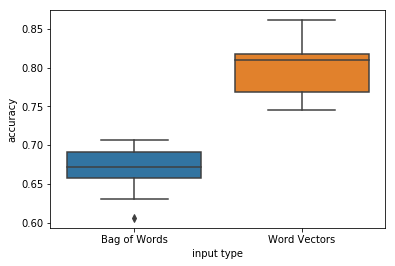

In [52]:
boxplot(x='input type', y='accuracy', data=conv_scores_data_frame)
plt.show()

Again our results look better. If this continues to be consistent we know that Word2Vec has some property that is beneficial, which may be training on more data, or it may be the higher vector dimensionality.

## Recurrent Neural Network (LSTM)

The final experiment we will run to test the results of using pretrained Word2Vec embeddings will be our LSTM network. 
In the previous test we did with word embeddings, our accuracy was 50%, so simply a random guess. Following the trend above of pretrained embeddings giving us better accuracies, we will run a test and see if this can give any improvements for the LSTM network.

First, let's get our BOW accuracies.

In [53]:
batches = 1600
padded = pad_sequences(bow_features)
rnn_bow = np.array(np.split(padded, batches))
max_len_bow = max([len(x) for x in padded])
rnn_bow_targets = np.array([[x] for x in labels])

In [54]:
def get_rnn_bow_model():
  model = Sequential([
      LSTM(20, input_shape=(1, max_len_bow)),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy', auroc, f1])
  return model

In [58]:
def evaluate_lstm_model(train_X, train_y, test_X, test_y):
    lstm_model = get_rnn_bow_model()
    return lstm_model.fit(train_X, train_y, epochs=25, batch_size=32, verbose=1, shuffle=False,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=6)], validation_data=(test_X, test_y))

In [59]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)
rnn_bow_scores = run_cross_validate(evaluate_lstm_model, rnn_bow, rnn_bow_targets, splitter, cv=5)

Train on 1440 samples, validate on 160 samples
Epoch 1/25
1440/1440 [==============================] - 4s 3ms/step - loss: 0.5215 - acc: 0.7861 - auroc: 0.8588 - f1: 0.8026 - val_loss: 0.3013 - val_acc: 0.8750 - val_auroc: 0.9549 - val_f1: 0.8610
Epoch 2/25
1440/1440 [==============================] - 0s 253us/step - loss: 0.1077 - acc: 0.9778 - auroc: 0.9980 - f1: 0.9771 - val_loss: 0.2464 - val_acc: 0.8812 - val_auroc: 0.9629 - val_f1: 0.8701
Epoch 3/25
1440/1440 [==============================] - 0s 249us/step - loss: 0.0362 - acc: 0.9993 - auroc: 1.0000 - f1: 0.9994 - val_loss: 0.2582 - val_acc: 0.8812 - val_auroc: 0.9566 - val_f1: 0.8701
Epoch 4/25
1440/1440 [==============================] - 0s 253us/step - loss: 0.0186 - acc: 0.9993 - auroc: 1.0000 - f1: 0.9994 - val_loss: 0.2700 - val_acc: 0.8812 - val_auroc: 0.9550 - val_f1: 0.8701
Epoch 5/25
1440/1440 [==============================] - 0s 259us/step - loss: 0.0116 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.2802 

1440/1440 [==============================] - 0s 263us/step - loss: 0.0422 - acc: 0.9993 - auroc: 1.0000 - f1: 0.9993 - val_loss: 0.2936 - val_acc: 0.9125 - val_auroc: 0.9526 - val_f1: 0.9056
Epoch 4/25
1440/1440 [==============================] - 0s 263us/step - loss: 0.0220 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.2964 - val_acc: 0.9187 - val_auroc: 0.9534 - val_f1: 0.9121
Epoch 5/25
1440/1440 [==============================] - 0s 264us/step - loss: 0.0139 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.3044 - val_acc: 0.9062 - val_auroc: 0.9510 - val_f1: 0.8978
Epoch 6/25
1440/1440 [==============================] - 0s 264us/step - loss: 0.0097 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.3100 - val_acc: 0.9000 - val_auroc: 0.9518 - val_f1: 0.8927
Epoch 7/25
1440/1440 [==============================] - 0s 262us/step - loss: 0.0073 - acc: 1.0000 - auroc: 1.0000 - f1: 1.0000 - val_loss: 0.3155 - val_acc: 0.8938 - val_auroc: 0.9510 - val_f1: 0.8866
E

In [60]:
rnn_bow_bests = results(rnn_bow_scores)
rnn_bow_bests, statistics.mean([x['val_accuracy'] for x in rnn_bow_bests])

([{'val_accuracy': 0.88125,
   'val_auroc': 0.9980491264769515,
   'val_f1': 0.87011159658432,
   'val_loss': 0.24641295075416564},
  {'val_accuracy': 0.8875,
   'val_auroc': 0.9999128540305011,
   'val_f1': 0.8837914228439331,
   'val_loss': 0.26799827814102173},
  {'val_accuracy': 0.85,
   'val_auroc': 0.9980598192943394,
   'val_f1': 0.8444301128387451,
   'val_loss': 0.2980100452899933},
  {'val_accuracy': 0.8875,
   'val_auroc': 0.996636531420458,
   'val_f1': 0.8871279716491699,
   'val_loss': 0.2951516032218933},
  {'val_accuracy': 0.8875,
   'val_auroc': 0.9975079734435383,
   'val_f1': 0.8872607111930847,
   'val_loss': 0.2753987699747086},
  {'val_accuracy': 0.8875,
   'val_auroc': 0.9999128540305011,
   'val_f1': 0.8707250356674194,
   'val_loss': 0.2961113005876541},
  {'val_accuracy': 0.8625,
   'val_auroc': 0.9981494636016051,
   'val_f1': 0.8597959280014038,
   'val_loss': 0.3750558733940125},
  {'val_accuracy': 0.9,
   'val_auroc': 1.0,
   'val_f1': 0.9018311142921448,


BOW again gives us astoundingly good accuracies, but of course, because it's over a tiny amount of data.

Now let's try our pretrained Word2Vec embeddings, and compare it to our previous OpSpam embeddings.

In [65]:
predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(raw_features))
max_len = max([len(x) for x in predictors_sequences])

In [61]:
def get_lstm_wv_model():
  model = Sequential([
        Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(10),
        Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc, f1])
  return model

In [63]:
def evaluate_lstm_model(train_X, train_y, test_X, test_y):
    lstm_model = get_lstm_wv_model()
    return lstm_model.fit(train_X, train_y, epochs=25, batch_size=32, verbose=1, shuffle=False,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=6)],
                          validation_data=(test_X, test_y))

In [68]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)
rnn_wv_scores = run_cross_validate(evaluate_lstm_model, predictors_sequences, labels, splitter, cv=5, verbose=1, epochs=12, batch_size=64, shuffle=True)

Train on 1440 samples, validate on 160 samples
Epoch 1/25
1440/1440 [==============================] - 35s 25ms/step - loss: 0.6877 - acc: 0.5465 - auroc: 0.5736 - f1: 0.6144 - val_loss: 0.6772 - val_acc: 0.6062 - val_auroc: 0.6574 - val_f1: 0.5762
Epoch 2/25
1440/1440 [==============================] - 28s 19ms/step - loss: 0.6691 - acc: 0.6146 - auroc: 0.6557 - f1: 0.6030 - val_loss: 0.6608 - val_acc: 0.6000 - val_auroc: 0.6692 - val_f1: 0.4732
Epoch 3/25
1440/1440 [==============================] - 28s 19ms/step - loss: 0.6280 - acc: 0.6493 - auroc: 0.7293 - f1: 0.6220 - val_loss: 0.6355 - val_acc: 0.5938 - val_auroc: 0.6833 - val_f1: 0.5922
Epoch 4/25
1440/1440 [==============================] - 28s 19ms/step - loss: 0.5590 - acc: 0.7104 - auroc: 0.8026 - f1: 0.7032 - val_loss: 0.6440 - val_acc: 0.6687 - val_auroc: 0.7627 - val_f1: 0.7034
Epoch 5/25
1440/1440 [==============================] - 28s 19ms/step - loss: 0.5454 - acc: 0.7590 - auroc: 0.8292 - f1: 0.7587 - val_loss: 0.567

Epoch 16/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.4876 - acc: 0.7771 - auroc: 0.8618 - f1: 0.7684 - val_loss: 0.5477 - val_acc: 0.7375 - val_auroc: 0.7930 - val_f1: 0.6912
Epoch 17/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.5026 - acc: 0.7549 - auroc: 0.8714 - f1: 0.7516 - val_loss: 0.5946 - val_acc: 0.7250 - val_auroc: 0.7811 - val_f1: 0.6437
Epoch 18/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.5175 - acc: 0.7500 - auroc: 0.8612 - f1: 0.6573 - val_loss: 0.8247 - val_acc: 0.5125 - val_auroc: 0.6902 - val_f1: 0.0421
Train on 1440 samples, validate on 160 samples
Epoch 1/25
1440/1440 [==============================] - 35s 24ms/step - loss: 0.6897 - acc: 0.5375 - auroc: 0.5786 - f1: 0.5908 - val_loss: 0.6821 - val_acc: 0.6125 - val_auroc: 0.6344 - val_f1: 0.5801
Epoch 2/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.6729 - acc: 0.6097 - auroc: 0.6643 - f1: 0.5827 - val_loss: 0.

Epoch 13/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.4058 - acc: 0.8326 - auroc: 0.9139 - f1: 0.8251 - val_loss: 0.5143 - val_acc: 0.7750 - val_auroc: 0.8689 - val_f1: 0.8004
Epoch 14/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.4078 - acc: 0.8340 - auroc: 0.9108 - f1: 0.8281 - val_loss: 0.4798 - val_acc: 0.7875 - val_auroc: 0.8723 - val_f1: 0.7526
Epoch 15/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.3602 - acc: 0.8646 - auroc: 0.9254 - f1: 0.8644 - val_loss: 0.4697 - val_acc: 0.7875 - val_auroc: 0.8774 - val_f1: 0.7710
Epoch 16/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.4743 - acc: 0.7889 - auroc: 0.9062 - f1: 0.7555 - val_loss: 0.4558 - val_acc: 0.7937 - val_auroc: 0.8824 - val_f1: 0.7985
Epoch 17/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.7680 - acc: 0.6694 - auroc: 0.8105 - f1: 0.7271 - val_loss: 1.0079 - val_acc: 0.5000 - val_auroc: 0.6876 - 

Epoch 11/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.7777 - acc: 0.5868 - auroc: 0.7597 - f1: 0.2525 - val_loss: 0.8042 - val_acc: 0.5000 - val_auroc: 0.6808 - val_f1: 0.0000e+00
Train on 1440 samples, validate on 160 samples
Epoch 1/25
1440/1440 [==============================] - 38s 26ms/step - loss: 0.6850 - acc: 0.5472 - auroc: 0.5986 - f1: 0.6327 - val_loss: 0.6840 - val_acc: 0.5875 - val_auroc: 0.6178 - val_f1: 0.4723
Epoch 2/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.6535 - acc: 0.6347 - auroc: 0.6975 - f1: 0.5945 - val_loss: 0.6273 - val_acc: 0.6562 - val_auroc: 0.7272 - val_f1: 0.7022
Epoch 3/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.6264 - acc: 0.6549 - auroc: 0.7500 - f1: 0.6859 - val_loss: 0.6099 - val_acc: 0.6813 - val_auroc: 0.7572 - val_f1: 0.6253
Epoch 4/25
1440/1440 [==============================] - 27s 19ms/step - loss: 0.6094 - acc: 0.6785 - auroc: 0.7705 - f1: 0.6874 - val_loss: 

In [69]:
rnn_wv_bests = results(rnn_wv_scores)
rnn_wv_bests, statistics.mean([x['val_accuracy'] for x in rnn_wv_bests])

([{'val_accuracy': 0.7125,
   'val_auroc': 0.8292466592181185,
   'val_f1': 0.6921764373779297,
   'val_loss': 0.5679287433624267},
  {'val_accuracy': 0.725,
   'val_auroc': 0.8380520032095434,
   'val_f1': 0.6826789379119873,
   'val_loss': 0.5591347813606262},
  {'val_accuracy': 0.75,
   'val_auroc': 0.8023204462412087,
   'val_f1': 0.726509940624237,
   'val_loss': 0.5326450049877167},
  {'val_accuracy': 0.8,
   'val_auroc': 0.870895269441935,
   'val_f1': 0.8061766386032104,
   'val_loss': 0.4710432469844818},
  {'val_accuracy': 0.6875,
   'val_auroc': 0.8028961450402692,
   'val_f1': 0.7177204012870788,
   'val_loss': 0.5881128549575806},
  {'val_accuracy': 0.79375,
   'val_auroc': 0.906195003916076,
   'val_f1': 0.7984665274620056,
   'val_loss': 0.4557736277580261},
  {'val_accuracy': 0.825,
   'val_auroc': 0.8966731104465266,
   'val_f1': 0.8199194669723511,
   'val_loss': 0.43167304396629336},
  {'val_accuracy': 0.75625,
   'val_auroc': 0.8121317108697788,
   'val_f1': 0.78211

In [70]:
rnn_scores_entries =[('Bag of Words', x['val_accuracy']) for x in rnn_bow_bests] + [('Word Vectors', x['val_accuracy']) for x in rnn_wv_bests]
rnn_scores_data_frame = DataFrame(rnn_scores_entries, columns=['input type', 'accuracy'])

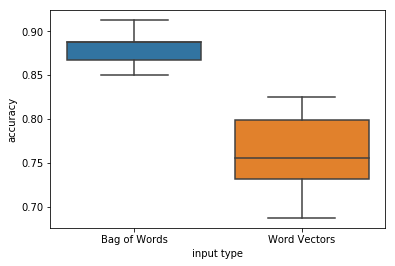

In [71]:
boxplot(x='input type', y='accuracy', data=rnn_scores_data_frame)
plt.show()

We are still seeing much higher results for BOW, however our pretrained vectors are doing better than the custom ones trained on the OpSpam dataset. This shows us conclusively that word embeddings do have some value, though perhaps not on a dataset as small as this. When we test over our full